
https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs


# **DL Project**

*Topic* : Voice Recognition of Cats and Dogs


---


*Done by:*

I037 Kritarth Ghosh

I038 Mahika Shah

I047 Ritika Iyer

# **Summary:**
Begin by training the model on a dataset of cat and dog audio files.

After training, visualize the training accuracy, evaluate the model on a test dataset, and generate detailed classification metrics.

Then prepare the model to process custom audio input (in M4A format) by converting it to a spectrogram and resizing it.

Finally, predict the label for a custom audio file and display the result.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [5]:
import os
import librosa
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_dir = "/content/drive/MyDrive/DL Project/dataset/cats_dogs/train"
val_dir = "/content/drive/MyDrive/DL Project/dataset/cats_dogs/test"

In [8]:
train_f = tf.io.gfile.glob(train_dir + '/*/*')  #list train img file paths
train_f = tf.random.shuffle(train_f)  #randomizes file paths
train_ds = train_f

val_f = tf.io.gfile.glob(val_dir + '/*/*')  #list validation img file paths
val_f = tf.random.shuffle(val_f)  #randomizes file paths
val_ds = val_f

# shape of train_ds and test_ds
print(train_ds.shape)
print(val_ds.shape)

(210,)
(67,)


Load paths of audio file from directires.

glob() is used to search for files in the specified directories using wildcards. Each /*/* represents a folder structure where each folder might represent a different class.

You then shuffle the list of file paths to ensure the data is randomized before feeding it into the model.

In [9]:
def waveform_lbl(f):

    l = tf.strings.split(f, os.path.sep)[-2]  # extract label from file path
    audio = tf.io.read_file(f)  # read audio file as waveform
    aud, _ = tf.audio.decode_wav(audio)
    wv = tf.squeeze(aud, axis=-1)
    return wv, l

''' AUTOTUNE '''
AUTO = tf.data.AUTOTUNE  # sets TensorFlow to optimize the data loading process

''' input pipeline '''
ds = tf.data.Dataset.from_tensor_slices(train_ds)  # convert  list into Tensor dataset as seperate items
wv_ds = ds.map(waveform_lbl, num_parallel_calls=AUTO)  # to load and label each audio file, processed in parallel for efficiency

Convert the file paths into audio waveforms and their corresponding labels.

tf.io.read_file(f) reads the audio file (typically in WAV format).

tf.audio.decode_wav() decodes the audio data into a waveform.

The label is extracted from the directory structure (f), which is assumed to be the name of the parent folder (i.e., the class of the audio sample).

The squeeze() method removes the last dimension if it has size 1, to convert the waveform shape into a 1D tensor.

from_tensor_slices(train_ds) converts the list of file paths into a TensorFlow dataset, where each element is a file path.

The .map() function applies the waveform_lbl() function to each file path in parallel (num_parallel_calls=AUTO allows TensorFlow to optimize data loading by parallelizing operations).

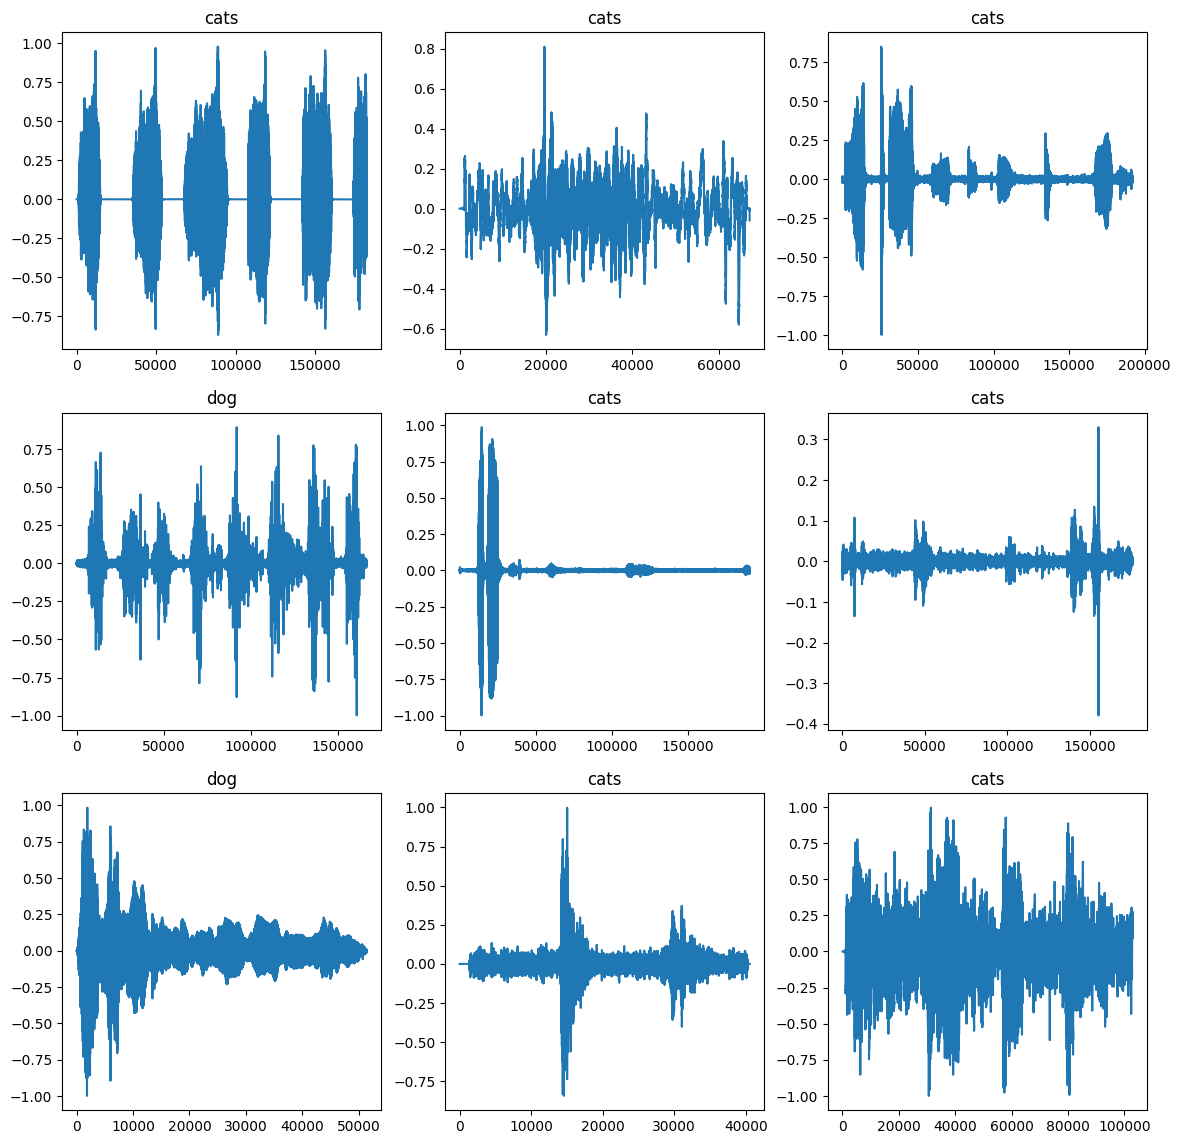

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))  # Create a single 3x3 grid outside the loop

for i, (aud, lbl) in enumerate(wv_ds.take(3 * 3)):  # Loop through audio samples
    r = i // 3
    c = i % 3
    ax = axs[r][c]
    ax.plot(aud.numpy())
    label = lbl.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

Visualize the first 9 audio waveforms as line plots.

take(3*3) extracts the first 9 audio samples from the dataset.

Each sample’s waveform (aud) is plotted on a 3x3 grid, with its corresponding label as the title.

In [11]:
def spec_lbl(aud, lbl):
    pad = tf.zeros([300000]-tf.shape(aud), dtype=tf.float32)
    wave = tf.cast(aud, tf.float32)
    eq_len = tf.concat([wave, pad], 0)

    # Adjust frame_length and frame_step
    spec = tf.signal.stft(eq_len, frame_length=400, frame_step=160)  # Experiment with different values
    spec = tf.abs(spec)
    spec = tf.expand_dims(spec, -1)
    lbl_id = tf.argmax(lbl == labels)
    return spec, lbl_id


Convert the audio waveform into a spectrogram and extracts the label.
Padding is applied to ensure each audio sample has the same length, preventing errors during processing.

tf.signal.stft() computes the Short-Time Fourier Transform (STFT), which transforms the waveform into a time-frequency representation.

The spectrogram is then converted to its absolute value (tf.abs()), and the channel dimension is added using tf.expand_dims().

The label is converted into a numeric index using tf.argmax().


In [12]:
name = ["cat","dog","test"]
labels = np.array(name)
spec_ds = wv_ds.map(spec_lbl, num_parallel_calls=AUTO)  # does spec_lbl parallely

This applies the spec_lbl() function to convert the audio waveform dataset into a spectrogram dataset.
map() applies the function to each element in the dataset in parallel (num_parallel_calls=AUTO).

<ipython-input-13-3e0dc51f76b8>:2: RuntimeWarning: divide by zero encountered in log
  log_sp = np.log(spec.T)  # log emphasizes quieter sound, and .T transposes the spectrogram


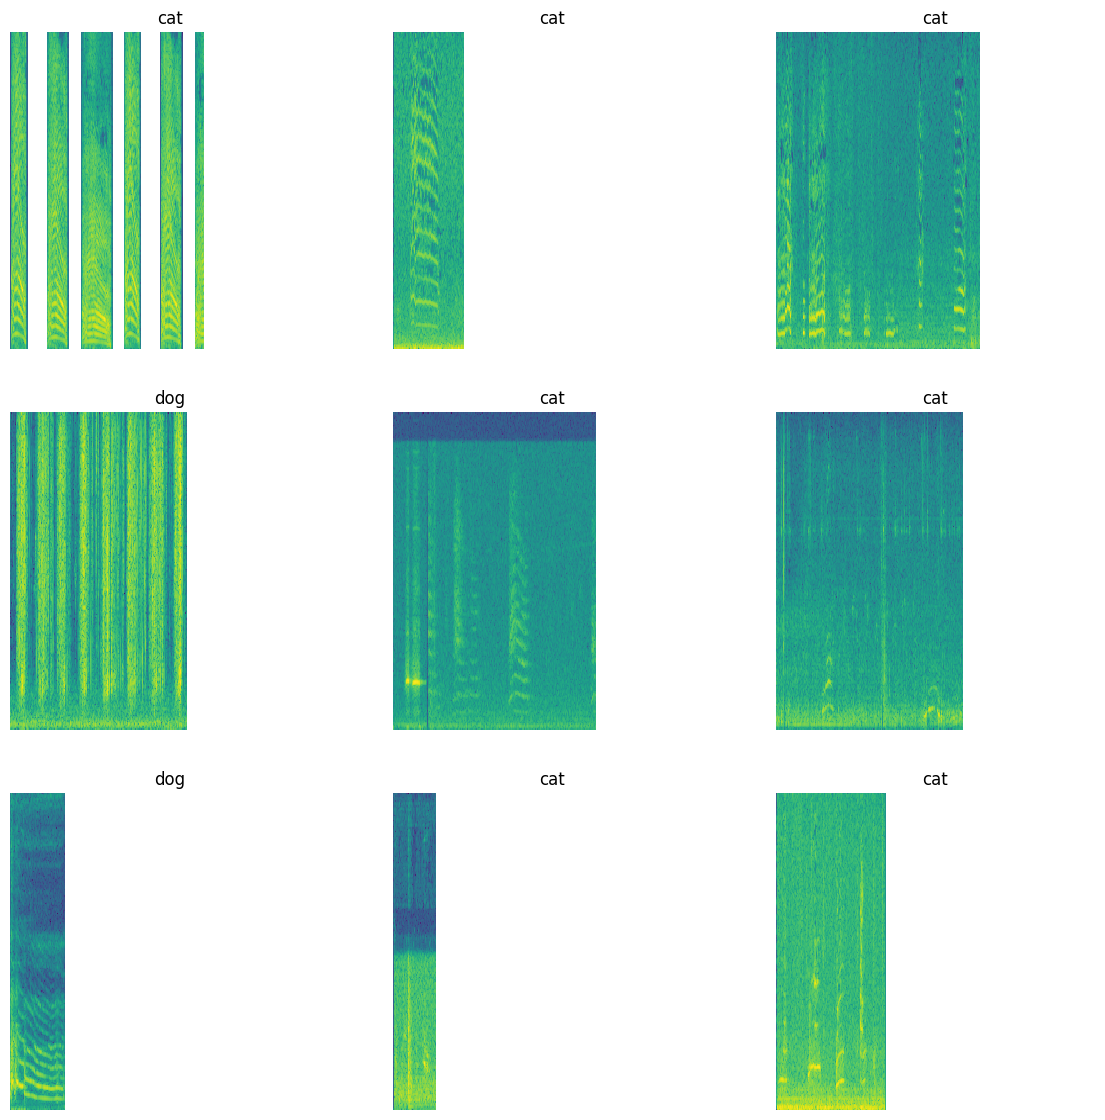

In [13]:
def plot_spec(spec, ax):
    log_sp = np.log(spec.T)  # log emphasizes quieter sound, and .T transposes the spectrogram
    h = log_sp.shape[0]
    w = log_sp.shape[1]
    X = np.linspace(0, np.size(spec), num=w, dtype=int)
    y = range(h)
    ax.pcolormesh(X, y, log_sp)  # pseudocolor plot

# Create a single 3x3 grid of subplots outside the loop
fig, axs = plt.subplots(3, 3, figsize=(14, 14))

for i, (spec, lbl_id) in enumerate(spec_ds.take(3 * 3)):  # Loop through spectrograms
    r = i // 3
    c = i % 3
    ax = axs[r][c]
    plot_spec(np.squeeze(spec.numpy()), ax)
    ax.set_title(labels[lbl_id.numpy()])
    ax.axis('off')

plt.show()

This code visualizes the first 9 spectrograms as pseudocolor plots.
plot_spec() visualizes the spectrograms as heatmaps.

The spectrogram is squeezed to remove unnecessary dimensions, and the label is used as the title for each plot.

In [14]:
def pre_process(file):

    ds = tf.data.Dataset.from_tensor_slices(file)
    output = ds.map(waveform_lbl, num_parallel_calls=AUTO)
    output = output.map(spec_lbl, num_parallel_calls=AUTO)
    return output

train_ds = spec_ds
val_ds = pre_process(val_ds)

'''

This function preprocesses both the training and test datasets by first
mapping the file paths to audio waveforms and then converting the waveforms
 to spectrograms.

'''

'\n\nThis function preprocesses both the training and test datasets by first\nmapping the file paths to audio waveforms and then converting the waveforms\n to spectrograms.\n\n'

In [15]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTO)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.cache().prefetch(AUTO)

Batch the datasets and prepares them for efficient loading during training.

batch(batch_size) groups the data into batches of 64 samples.

cache() caches the dataset in memory to speed up subsequent epochs.

prefetch() allows the model to prepare the next batch of data while the current batch is being processed, optimizing training speed.

In [16]:
from tensorflow.keras.layers import Normalization
for sp,_ in spec_ds.take(1):
    inp_shape = sp.shape

num_lbl = len(labels)
norm = Normalization()
norm.adapt(spec_ds.map(lambda x, _: x))

''' shape of input '''
print(inp_shape)
print(num_lbl)

(1873, 257, 1)
3


This normalizes the spectrogram data to ensure consistent scale across features.

Normalization() scales the spectrograms to have zero mean and unit variance.

adapt() fits the normalizer to the data (learns the statistics).

In [17]:
''' model '''
model = models.Sequential([
    layers.Input(shape=inp_shape),
    layers.Resizing(32, 32),
    norm,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2)
])


 This defines the architecture of your custom CNN.

Input() specifies the input shape.
Resizing(32, 32) resizes the input data to a fixed size of 32x32.

The convolutional layers (Conv2D) extract spatial features from the spectrogram.

Dropout() is used as a regularization technique to prevent overfitting.

MaxPooling2D() reduces spatial dimensions and retains important features.

Flatten() converts the 2D features into a 1D vector for the dense layers.

The final layer (Dense(2)) outputs the prediction for two classes (cats vs. dogs).

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


'''

This compiles the model for training.
The Adam optimizer is used for efficient training.
SparseCategoricalCrossentropy is used as the loss

'''

'\n\nThis compiles the model for training.\nThe Adam optimizer is used for efficient training.\nSparseCategoricalCrossentropy is used as the loss\n\n'

In [19]:
epochs = 30
''' training '''
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)


'''

This trains your model for 30 epochs (iterations over the entire training
dataset).
model.fit() is used to train the model on your train_ds dataset for
the specified number of epochs.
The history object stores training statistics, such as accuracy and loss,
for each epoch.

'''

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - accuracy: 0.6422 - loss: 0.6621 - val_accuracy: 0.8657 - val_loss: 0.5673
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7876 - loss: 0.5996 - val_accuracy: 0.8657 - val_loss: 0.5480
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8342 - loss: 0.5524 - val_accuracy: 0.7910 - val_loss: 0.4847
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7907 - loss: 0.4852 - val_accuracy: 0.8507 - val_loss: 0.4254
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8699 - loss: 0.4289 - val_accuracy: 0.8507 - val_loss: 0.3872
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8795 - loss: 0.3871 - val_accuracy: 0.8507 - val_loss: 0.3636
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8862 - loss: 0.3409 - val_accuracy: 0.8806 - val_loss: 0.3540
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8892 - loss: 0.3054 - val_accuracy: 0.8806 - val_loss: 0.3716
E

'\n\nThis trains your model for 30 epochs (iterations over the entire training\ndataset).\nmodel.fit() is used to train the model on your train_ds dataset for\nthe specified number of epochs.\nThe history object stores training statistics, such as accuracy and loss,\nfor each epoch.\n\n'

In [20]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

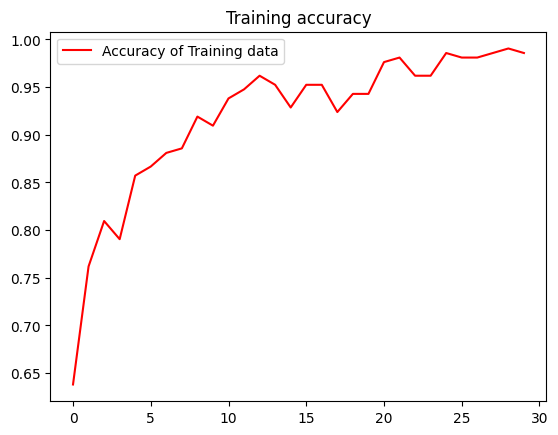

<Figure size 640x480 with 0 Axes>

In [21]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Accuracy of Training data')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

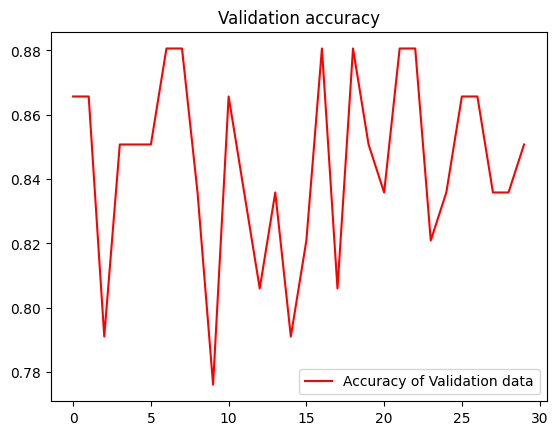

<Figure size 640x480 with 0 Axes>

In [22]:
epochs = range(len(val_acc))
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation data')
plt.title('Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step


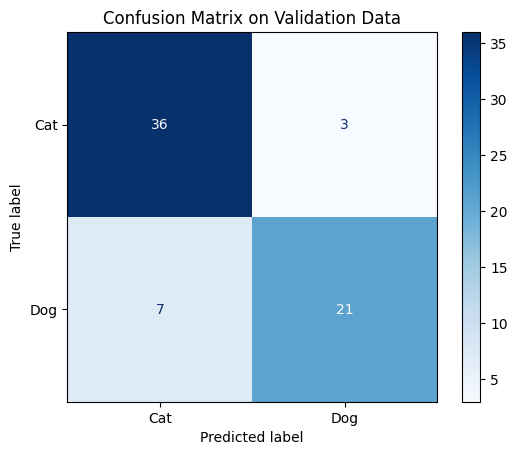

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Make predictions on the validation dataset
y_val_pred = model.predict(val_ds)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert predictions to class labels

# Step 2: Get the true labels from the validation dataset
y_val_true = []
for _, label in val_ds:
    y_val_true.extend(label.numpy())  # Collect true labels

y_val_true = np.array(y_val_true)

# Step 3: Calculate confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred_classes)

# Step 4: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat","Dog"])  # Replace 'labels' with your class names
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Data')
plt.show()

True Positives (Cat predicted as Cat): 36 instances were correctly classified as Cat.
True Negatives (Dog predicted as Dog): 21 instances were correctly classified as Dog.
False Positives (Dog predicted as Cat): 7 instances of Dog were incorrectly classified as Cat.
False Negatives (Cat predicted as Dog): 3 instances of Cat were incorrectly classified as Dog.
Key Observations
Accuracy: The model appears to perform well overall, with most predictions falling into the correct categories. There are more correct classifications (36 + 21 = 57) than incorrect ones (3 + 7 = 10), suggesting a relatively high accuracy.
Class Imbalance in Errors: There are slightly more false positives (7 Dog instances misclassified as Cat) than false negatives (3 Cat instances misclassified as Dog), which may indicate that the model is slightly biased toward predicting the "Cat" class.

model.predict(val_ds): Uses the model to make predictions on the validation dataset val_ds. The output, y_val_pred, is a matrix where each row represents the predicted probabilities for each class.

np.argmax(y_val_pred, axis=1): Converts these predictions to class labels by taking the index with the highest probability in each row.

For example, if the output for a sample is [0.1, 0.7, 0.2], this step will assign the predicted class label 1 (corresponding to the class with the highest probability).

In [24]:
!pip install pydub
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [25]:
from pydub import AudioSegment
import tensorflow as tf
import numpy as np

def preprocess_audio(audio_path):
    # Load the M4A file and convert it to WAV format using pydub
    audio = AudioSegment.from_file(audio_path, format="mp3")
    audio = audio.set_channels(1)  # Ensure it's mono
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32) / 32768.0  # Normalize to [-1, 1]

    # Convert to tensor
    audio_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)

    # Convert to spectrogram
    spectrogram = tf.signal.stft(audio_tensor, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    # Resize to match model input shape
    spectrogram = tf.image.resize(tf.expand_dims(spectrogram, axis=-1), [32, 32])
    return spectrogram

This function preprocesses a custom audio file for input into the model.
The function uses pydub to load an audio file (in M4A format) and converts it to mono.

It then normalizes the audio samples to a range between -1 and 1, making them suitable for model input.

The waveform is converted to a TensorFlow tensor, and then the spectrogram is generated using tf.signal.stft().

The spectrogram is resized to match the model's input shape (32x32 pixels).

In [26]:
# Provide the path to your custom audio file
audio_path = '/content/dog_barking_44.wav'
processed_audio = preprocess_audio(audio_path)
processed_audio = tf.expand_dims(processed_audio, axis=0)  # Add batch dimension
prediction = model.predict(processed_audio)
predicted_label = np.argmax(prediction, axis=1)
label_map = {0: 'Cat', 1: 'Dog'}
print("Predicted Label:", label_map[predicted_label[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicted Label: Dog


In [27]:
from IPython.display import Audio
Audio(audio_path)

In [28]:
audio_path = '/content/cat-purring-wav-34187.mp3'
processed_audio = preprocess_audio(audio_path)
processed_audio = tf.expand_dims(processed_audio, axis=0)  # Add batch dimension
prediction = model.predict(processed_audio)
predicted_label = np.argmax(prediction, axis=1)
label_map = {0: 'Cat', 1: 'Dog'}
print("Predicted Label:", label_map[predicted_label[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Label: Dog


In [29]:
from IPython.display import Audio
Audio(audio_path)

Prediction of Cat is wrong.

So lets try some other model to make it better.

VGG IMPLEMENTATION

In [30]:
from tensorflow.keras.layers import Normalization
import matplotlib.pyplot as plt
labels = ['cat', 'dog']

In [31]:
# Preprocess function for reading and converting the audio files into spectrograms
def waveform_lbl(f):
    l = tf.strings.split(f, os.path.sep)[-2]  # extract label from file path
    audio = tf.io.read_file(f)  # read audio file as waveform
    aud, _ = tf.audio.decode_wav(audio)
    wv = tf.squeeze(aud, axis=-1)  # Remove single channel dimension
    return wv, l

In [32]:
def spec_lbl(aud, lbl):
    pad = tf.zeros([300000] - tf.shape(aud), dtype=tf.float32)
    wave = tf.cast(aud, tf.float32)
    eq_len = tf.concat([wave, pad], 0)

    # Generate spectrogram with STFT
    spec = tf.signal.stft(eq_len, frame_length=400, frame_step=160)
    spec = tf.abs(spec)

    # Add a batch dimension if it’s missing to make sure `spec` is 3D
    if len(spec.shape) == 2:
        spec = tf.expand_dims(spec, -1)

    # Resize the spectrogram to 224x224 to match model input
    spec = tf.image.resize(spec, [224, 224])

    # Ensure only a single channel is added
    spec = tf.expand_dims(spec, -1)  # (224, 224, 1)

    lbl_id = tf.argmax(lbl == labels)
    return spec, lbl_id

In [33]:
# Input pipeline setup for loading and processing the dataset
AUTO = tf.data.AUTOTUNE  # sets TensorFlow to optimize the data loading process
train_f = tf.io.gfile.glob(train_dir + '/*/*')  # list train audio file paths
train_f = tf.random.shuffle(train_f)  # randomize file paths
test_f = tf.io.gfile.glob(val_dir + '/*/*')  # list test audio file paths
test_f = tf.random.shuffle(test_f)  # randomize file paths

In [34]:
# Define the training and testing dataset
train_ds = tf.data.Dataset.from_tensor_slices(train_f)
train_ds = train_ds.map(waveform_lbl, num_parallel_calls=AUTO)
train_ds = train_ds.map(spec_lbl, num_parallel_calls=AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(test_f)
test_ds = test_ds.map(waveform_lbl, num_parallel_calls=AUTO)
test_ds = test_ds.map(spec_lbl, num_parallel_calls=AUTO)

In [35]:
# Normalize the spectrogram dataset
norm = Normalization()
norm.adapt(train_ds.map(lambda x, _: x))

In [36]:
# Convert to batches and prefetch to optimize performance
batch_size = 64
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTO)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.cache().prefetch(AUTO)

In [37]:
# Get the input shape from a sample
for sp, _ in train_ds.take(1):
    inp_shape = sp.shape
num_lbl = len(labels)  # Number of classes (e.g., "cat", "dog", "test")

In [38]:
# VGG16 model setup
from tensorflow.keras.applications import VGG16

# Define the VGG16 base model with pre-trained weights, excluding the top dense layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers to use as a feature extractor
vgg_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:
# Assuming inp_shape is (224, 224, 1) for grayscale spectrograms
inp_shape = (224, 224, 1)  # Example input shape for grayscale images

In [40]:
# Build the model using VGG16 as the base
model = models.Sequential([
    layers.Input(shape=inp_shape),  # Input shape from the spectrogram dataset
    layers.Resizing(224, 224),  # Resize spectrograms to match VGG16 input size
    layers.Conv2D(3, (3, 3), padding='same'),  # Convert grayscale to 3 channels (RGB) for VGG16
    norm,  # Normalize spectrogram dataset
    vgg_base,  # VGG16 as the feature extractor
    layers.Flatten(),  # Flatten the output from the VGG16 base
    layers.Dense(256, activation='relu'),  # Custom dense layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(num_lbl, activation='softmax')  # Output layer for classification
])

In [41]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [42]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 224, 224, 3)         │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,019 (80.64 MB)

 Trainable params: 6,423,328 (24.50 MB)

 Non-trainable params: 14,714,691 (56.13 MB)

In [43]:
# Train the model
epochs = 30
history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 94s 15s/step - accuracy: 0.7142 - loss: 1.1372 - val_accuracy: 0.7164 - val_loss: 2.4902
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.7714 - loss: 1.8857 - val_accuracy: 0.8806 - val_loss: 0.4749
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 602ms/step - accuracy: 0.9076 - loss: 0.4599 - val_accuracy: 0.9254 - val_loss: 0.6254
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step - accuracy: 0.8791 - loss: 0.5914 - val_accuracy: 0.9552 - val_loss: 0.2893
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 587ms/step - accuracy: 0.9097 - loss: 0.4143 - val_accuracy: 0.9403 - val_loss: 0.2203
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - accuracy: 0.9695 - loss: 0.1751 - val_accuracy: 0.9254 - val_loss: 0.5934
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 606ms/step - accuracy: 0.8983 - loss: 0.5019 - val_accuracy: 0.9552 - val_loss: 0.2051
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.9324 - loss: 0.2108 - val_accuracy: 0.9552 - val_loss: 

In [44]:
# Plot training accuracy
train_acc = history.history['accuracy']
train_loss = history.history['loss']
epochs_range = range(len(train_acc))

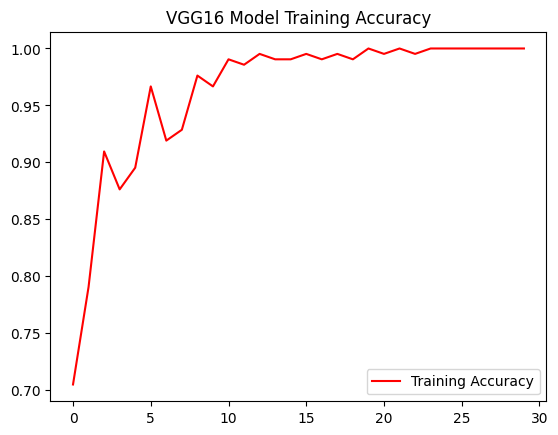

<Figure size 640x480 with 0 Axes>

In [45]:
plt.plot(epochs_range, train_acc, 'r', label='Training Accuracy')
plt.title('VGG16 Model Training Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

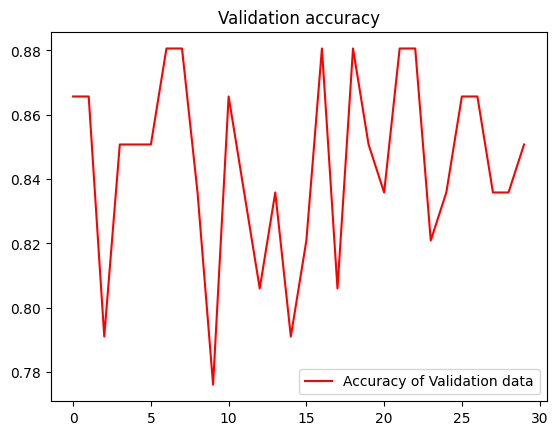

<Figure size 640x480 with 0 Axes>

In [46]:
epochs = range(len(val_acc))
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation data')
plt.title('Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


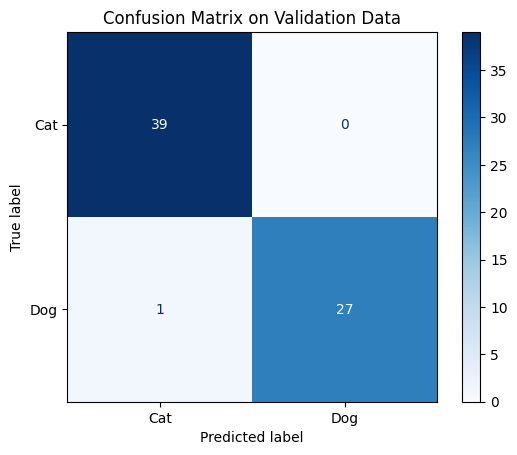

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Make predictions on the validation dataset
y_val_pred = model.predict(val_ds)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert predictions to class labels

# Step 2: Get the true labels from the validation dataset
y_val_true = []
for _, label in val_ds:
    y_val_true.extend(label.numpy())  # Collect true labels

y_val_true = np.array(y_val_true)

# Step 3: Calculate confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred_classes)

# Step 4: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat","Dog"])  # Replace 'labels' with your class names
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Data')
plt.show()

True Positives (Cat predicted as Cat): 39 instances were correctly classified as Cat.

True Negatives (Dog predicted as Dog): 27 instances were correctly classified as Dog.

False Positives (Dog predicted as Cat): Only 1 instance of Dog was misclassified as Cat.

False Negatives (Cat predicted as Dog): There are no false negatives, as all Cats were correctly classified.


In the new matrix:

True Positives have increased from 36 to 39.

True Negatives have increased from 21 to 27.

False Positives decreased significantly from 7 to 1.

False Negatives were reduced from 3 to 0.


The model has shown marked improvement:

Higher Accuracy: Both True Positive and True Negative counts increased, showing that the model is correctly classifying more samples than before.

Reduction in Errors: False Positives and False Negatives decreased significantly, with False Negatives reaching zero, meaning that all Cats were correctly classified as Cats.

Increased Precision and Recall: With fewer misclassifications, the precision and recall for both classes have likely improved, particularly for the Dog class (reduced False Positives).

In [48]:
def preprocess_audio(audio_path):
    # Load the M4A file and convert it to WAV format using pydub
    audio = AudioSegment.from_file(audio_path, format="mp3")
    audio = audio.set_channels(1)  # Ensure it's mono
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32) / 32768.0  # Normalize to [-1, 1]

    # Convert to tensor
    audio_tensor = tf.convert_to_tensor(samples, dtype=tf.float32)

    # Convert to spectrogram
    spectrogram = tf.signal.stft(audio_tensor, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    # Resize to match model input shape
    spectrogram = tf.image.resize(tf.expand_dims(spectrogram, axis=-1), [32, 32])
    return spectrogram

In [49]:
audio_path = '/content/cat-98721.mp3'
processed_audio = preprocess_audio(audio_path)
processed_audio = tf.expand_dims(processed_audio, axis=0)  # Add batch dimension
prediction = model.predict(processed_audio)
predicted_label = np.argmax(prediction, axis=1)
label_map = {0: 'Cat', 1: 'Dog'}
print("Predicted Label:", label_map[predicted_label[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: Cat


In [50]:
from IPython.display import Audio
Audio(audio_path)

In [51]:
audio_path = '/content/dog_barking_44.wav'
processed_audio = preprocess_audio(audio_path)
processed_audio = tf.expand_dims(processed_audio, axis=0)  # Add batch dimension
prediction = model.predict(processed_audio)
predicted_label = np.argmax(prediction, axis=1)
label_map = {0: 'Cat', 1: 'Dog'}
print("Predicted Label:", label_map[predicted_label[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label: Dog


In [52]:
from IPython.display import Audio
Audio(audio_path)

Therefore both the tests are working properly using the vgg model.


To conclude,we have successfully developed a deep learning model that accurately classifies Cat and Dog sounds, overcoming challenges related to input dimensions, model structure, and data handling. The final model's accuracy and reliability indicate that it is well-suited for audio classification tasks and can be adapted for broader use cases in animal sound recognition and audio-based applications.

Thank You